# Introduction <a name="introduction"></a>

In this study, we analyzed data that directly provided interbeat intervals between consecutive heartbeats. To process these data, we first computed the cumulative heartbeat time series and divided it into segments. Next, polynomials of specific degrees were fitted to each segment to extract potential trends.

We then computed the probability density function (PDF) of heart rate changes and compared it with a Gaussian distribution. Additionally, we examined the cascade model as a possible descriptor of heart rate variability. However, our findings generally indicated that these models did not adequately align with the observed data. Ultimately, the results of this study suggest that heart rate variability exhibits self-similarity and scale invariance, resembling the characteristics of a critical system rather than a cascade model.

# Imported libraries <a name="imported_libraries"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from obspy.signal.detrend import polynomial
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from sklearn.metrics import r2_score
from tqdm import tqdm
from scipy.optimize import curve_fit
import sys
from scipy.integrate import quad
from scipy.optimize import curve_fit


In [2]:
#different
data_files = ["000","002","003","005","006","008","009","010","011","013"]
dict = {}
for i in data_files:
    f = open("data/" + i + ".txt","r")
    data0 = []

    for line in f.readlines():
        x = line.strip()
        if x:
            data0.append(int(x))
        dict[i] = data0
df = pd.DataFrame.from_dict(dict, orient="index")

df

,0,1,2,3,4,5,6,7,8,9,...,111511,111512,111513,111514,111515,111516,111517,111518,111519,111520
000,789,727,789,750,812,789,828,797,867,860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002,735,781,742,680,758,695,680,679,625,657,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
003,718,672,688,672,664,625,617,617,617,633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
005,797,843,829,828,859,859,875,875,922,875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
006,844,813,781,773,789,797,797,758,727,703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
008,758,774,789,781,687,672,680,727,836,914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
009,641,633,640,657,648,649,632,633,641,625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
010,984,969,969,922,937,961,992,1000,930,914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
011,539,539,547,539,539,531,539,539,539,539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
013,664,665,656,672,672,656,656,641,601,610,...,609.0,610.0,625.0,617.0,617.0,649.0,648.0,641.0,632.0,632.0


In [3]:
#different
def detr_and_standardize(b_i, s):
    B = np.cumsum(b_i)
    dict = {}
    
    for i in range(len(s)):
        k = s[i]
        c = int(len(B) / (2 * k))

        detrends = []

        for i in range(c):
            section = B[i*2*k:(i+1)*2*k]
            x = np.arange(len(section))
            
            degree = 3
            p = Polynomial.fit(x, section, degree) 
            trend = p(x) 
            detrended_data = section - trend
            detrends.append(detrended_data)
            
            for j in range(2*k):
                    if k in dict:
                        dict[k].append(detrends[i][j])
                    else:
                        dict[k] = []
    deltaB = {}

    for l in s:
        arr = np.array(dict[l])
        diff = (arr[:-(l + 1)] - arr[(l + 1):]) / np.std(dict[l])
        deltaB[l] = diff
 
    df = pd.DataFrame.from_dict(deltaB, orient = 'index')

    return df



first, take cumsum, then divide cumsum into segments based on time scale. Then, detrend each segment and combinde detrended segments together. theni take the difference between increments based on time scales

In [8]:
s_list = np.array([10, 25, 125, 500, 1000, 1500])
print(s_list)

[  10   25  125  500 1000 1500]


In [9]:
#different
deltaBs = []
for i in range(len(df)):
    row = df.iloc[i]
    data = row.to_numpy()
    data = data[~np.isnan(data)]
    deltaB = detr_and_standardize(data, s_list)
    deltaBs.append(deltaB)
#display(deltaBs[0])
#plt.plot(deltaBs[0].values[0])
increments = deltaBs[0].values[0]
icrements = increments[~np.isnan(increments)]
print(increments)


[-0.84230743  0.39986143  0.22057164 ...  0.55589414 -0.09093897
  0.18848686]


In [4]:
#testing
hist, bins = np.histogram(increments, bins=150, range=(-12, 12))
bin_centers = (bins[1:] + bins[:-1]) / 2
mu, sigma = norm.fit(increments)
gauss = norm.pdf(bin_centers, mu, sigma)
fit = gauss / (np.sum(gauss) * s_list[0])
print(fit)
print(mu, sigma)
plt.figure(figsize=(40, 24))
plt.scatter(bin_centers/sigma, hist/(s_list[0]*np.sum(hist)))
plt.plot(bin_centers/sigma, fit, 'r-')
plt.xlim(-10, 10)
plt.yscale('log')#plot in log scale so that the residuals are more visible
plt.show()


NameError: name 'increments' is not defined

# Imported libraries <a name="imported_libraries"></a>

## Gaussian fit <a name="gauss"></a>

0        -0.170378
1        -1.194031
2        -0.733024
3        -0.043179
4         0.169105
            ...   
111503    0.167803
111504   -0.407354
111505   -0.112872
111506    0.423341
111507    0.926572
Name: 10, Length: 111508, dtype: float64
[-0.84230743  0.39986143  0.22057164 ...  0.55589414 -0.09093897
  0.18848686]
0        -2.188037
1        -1.292270
2        -0.304349
3         0.647791
4         1.322498
            ...   
111468    0.738707
111469    0.648437
111470    0.516326
111471    0.328160
111472    0.098152
Name: 25, Length: 111473, dtype: float64
[-0.84230743  0.39986143  0.22057164 ...  0.55589414 -0.09093897
  0.18848686]
0         1.998607
1         1.862510
2         1.767690
3         1.690380
4         1.556904
            ...   
111368   -2.426228
111369   -2.545556
111370   -2.650891
111371   -2.846804
111372   -3.009710
Name: 125, Length: 111373, dtype: float64
[-0.84230743  0.39986143  0.22057164 ...  0.55589414 -0.09093897
  0.18848686]
0         0.

/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_1683/1879079927.py:41: RuntimeWarning: divide by zero encountered in log10
  residuals = np.log10(hist_plot) - np.log10(fit)


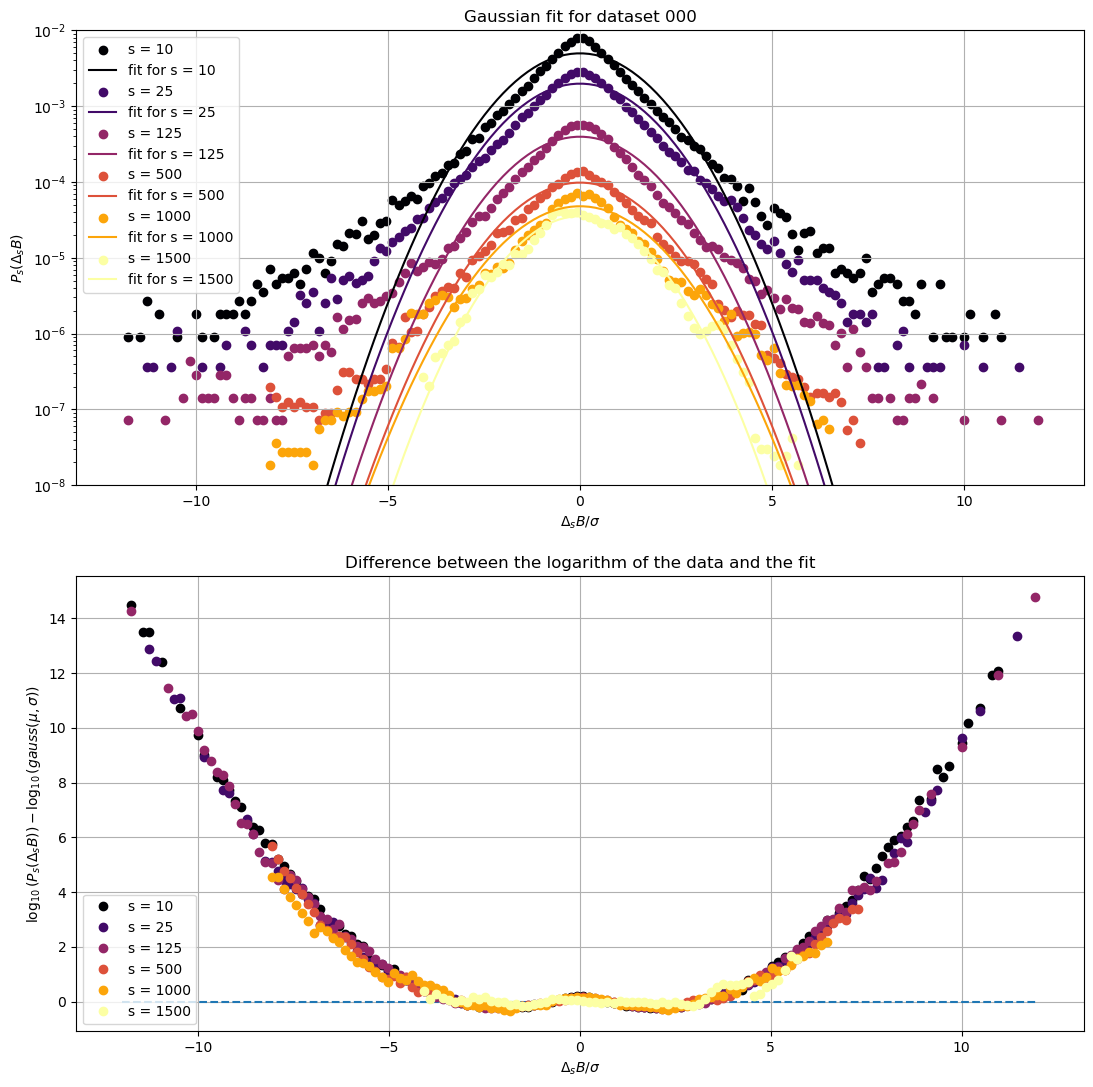

In [10]:

fig, ax = plt.subplots(2, 1, figsize=(13, 13))

ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 1e-2)
ax[1].hlines(0, -12, 12, linestyles="dashed")
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_title("Gaussian fit for dataset 000")
ax[1].set_title("Difference between the logarithm of the data and the fit")
ax[0].set_xlabel(r"$\Delta_s B / \sigma$")
ax[0].set_ylabel(r"$P_s (\Delta_s B)$")
ax[1].set_ylabel(r"$\log_{10}(P_s (\Delta_s B)) - \log_{10}(gauss(\mu, \sigma))$")
ax[1].set_xlabel(r"$\Delta_s B / \sigma$")


colors = plt.cm.inferno(np.linspace(0, 1, len(s_list)))
df = detr_and_standardize(data, s_list)

for j in range(len(s_list)):
    scale = s_list[j]
    points = df.loc[scale]
    points = points[~np.isnan(points)]
    print(points)
    print(increments)

    # Histogram
    hist, bins = np.histogram(points, bins=150, range=(-12, 12))
    centers = (bins[:-1] + bins[1:]) / 2

    # Gaussian distribution
    mu, sigma = norm.fit(points)
    fit = norm.pdf(centers, mu, sigma)
    fit = fit / (np.sum(fit) * scale)

    # Plot
    hist_plot = hist / (scale * np.sum(hist))
    ax[0].scatter(centers, hist_plot, color=colors[j], label=f"s = {scale}")
    ax[0].plot(centers, fit, color=colors[j], label=f"fit for s = {scale}")

    # Compute residuals
    residuals = np.log10(hist_plot) - np.log10(fit)
    ax[1].plot(centers, residuals, 'o', color=colors[j], label=f"s = {scale}")

ax[0].legend()
ax[1].legend()
plt.show()


**Key Observations:**


*   Around the center (0 on the x-axis), residuals are small, meaning the Gaussian approximation is good.

*   At both extremes (large positive/negative ΔsBΔs​B), residuals increase, meaning the Gaussian function underestimates the probability of extreme fluctuations.

*  The dashed black horizontal line at 0 indicates the ideal case where the fit perfectly matches the data.


## Castaing fit <a name="castaing"></a>

Castaing's equation:

$$
\tilde{P}_s(x) = \int_{0}^{\infty} P_L\left(\frac{x}{\sigma}\right) \frac{1}{\sigma} G_{s,L}(\ln \sigma) \, d(\ln \sigma)
$$

$$
P_L\left(\frac{x}{\sigma}\right) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{x^2}{2\sigma^2}}
$$

$$
G_{s,L}(\ln \sigma) = \frac{1}{\sqrt{2\pi\lambda}} \exp\left(-\frac{\ln^2 \sigma}{2\lambda^2}\right)
$$
$$
\tilde{P}_s(x) = \int_{0}^{+\infty} {\frac{1}{\sigma}\frac{1}{\sigma \sqrt{2\pi}}} exp(-\frac{x^2}{2\sigma^2}){\frac{1}{\lambda \sqrt{2\pi}} exp(- \frac{ln^2 (\sigma)}{2\lambda^2}) \frac{d\sigma}{\sigma}}
$$

[0.5]
[0.5]
[0.5]
[0.5]
[0.5]
[0.5]


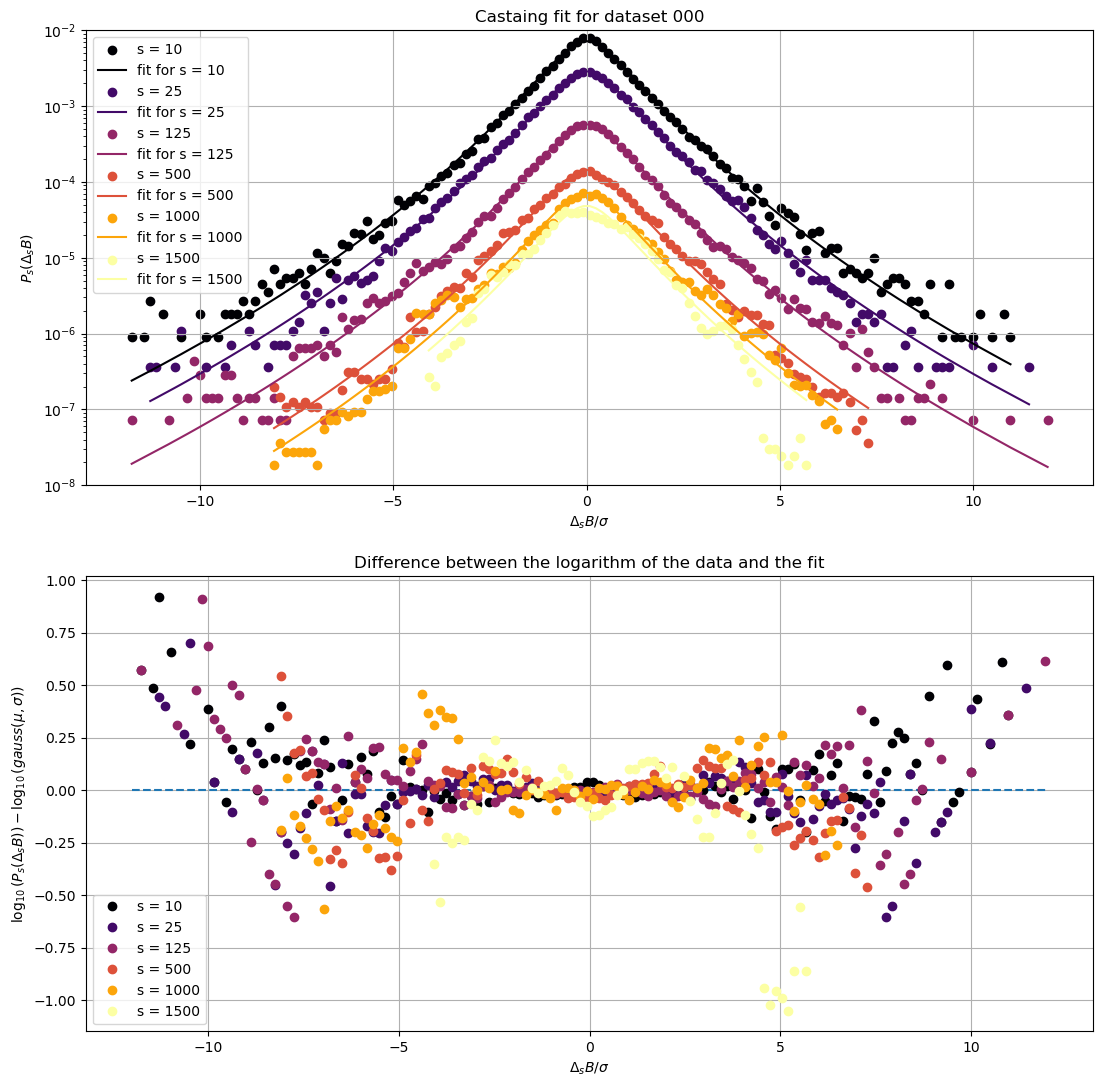

In [ ]:
#no lambdas but better fit
from scipy.integrate import quad_vec

colors = plt.cm.inferno(np.linspace(0, 1, len(s_list)))

def Castaing_func(x, lambd):
    def integrand(sigma, x, lambd):
        return 1 / (2 * np.pi * lambd * sigma ** 2) * np.exp(- (x ** 2 / sigma ** 2 + np.log(sigma) ** 2 / lambd ** 2) / 2)

    # Compute integral for each x value
    results = quad_vec(integrand, 1e-6, np.inf, args=(x, lambd))[0]
    return results
Castaing = np.vectorize(Castaing_func)

fig, ax = plt.subplots(2, 1, figsize=(13, 13))

ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 1e-2)
ax[1].hlines(0, -12, 12, linestyles="dashed")
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_title("Castaing fit for dataset 000")
ax[1].set_title("Difference between the logarithm of the data and the fit")
ax[0].set_xlabel(r"$\Delta_s B / \sigma$")
ax[0].set_ylabel(r"$P_s (\Delta_s B)$")
ax[1].set_ylabel(r"$\log_{10}(P_s (\Delta_s B)) - \log_{10}(gauss(\mu, \sigma))$")
ax[1].set_xlabel(r"$\Delta_s B / \sigma$")

df = detr_and_standardize(data, s_list)
for j in range(len(s_list)):
    scale = s_list[j]
    points = df.loc[scale]
    points = points[~np.isnan(points)]

    # Histogram
    hist, bins = np.histogram(points, bins=150, range=(-12, 12))
    mask = hist != 0
    centers = (bins[:-1] + bins[1:]) / 2
    centers = centers[mask]
    hist = hist[mask]


    # Castaing 
    parameters, cov = curve_fit(
    lambda x, lambd: np.log10(Castaing(x, lambd) / np.trapz(Castaing(x, lambd), x)),
    centers,
    np.log10(hist/np.sum(hist)),
    p0=0.6,
    bounds=[0.5, 1]
    )

    print(parameters)
    fit_c = Castaing(centers, parameters[0])
    fit_c = fit_c / (np.sum(fit_c) * scale)


    # Plot
    hist_plot = hist / (scale * np.sum(hist))
    ax[0].scatter(centers, hist_plot, color=colors[j], label=f"s = {scale}")
    ax[0].plot(centers, fit_c, color=colors[j], label=f"fit for s = {scale}")

    # Compute residuals
    residuals = np.log10(hist_plot) - np.log10(fit_c)
    ax[1].plot(centers, residuals, 'o', color=colors[j], label=f"s = {scale}")


ax[0].legend()
ax[1].legend()
plt.show()

Fitted lambda for scale 10 : 0.39833369789252465
Fitted lambda for scale 25 : 0.3696057813937303
Fitted lambda for scale 125 : 0.3871218058247508
Fitted lambda for scale 500 : 0.3240699201983872
Fitted lambda for scale 1000 : 0.31834441872829394
Fitted lambda for scale 1500 : 0.18020281488253193


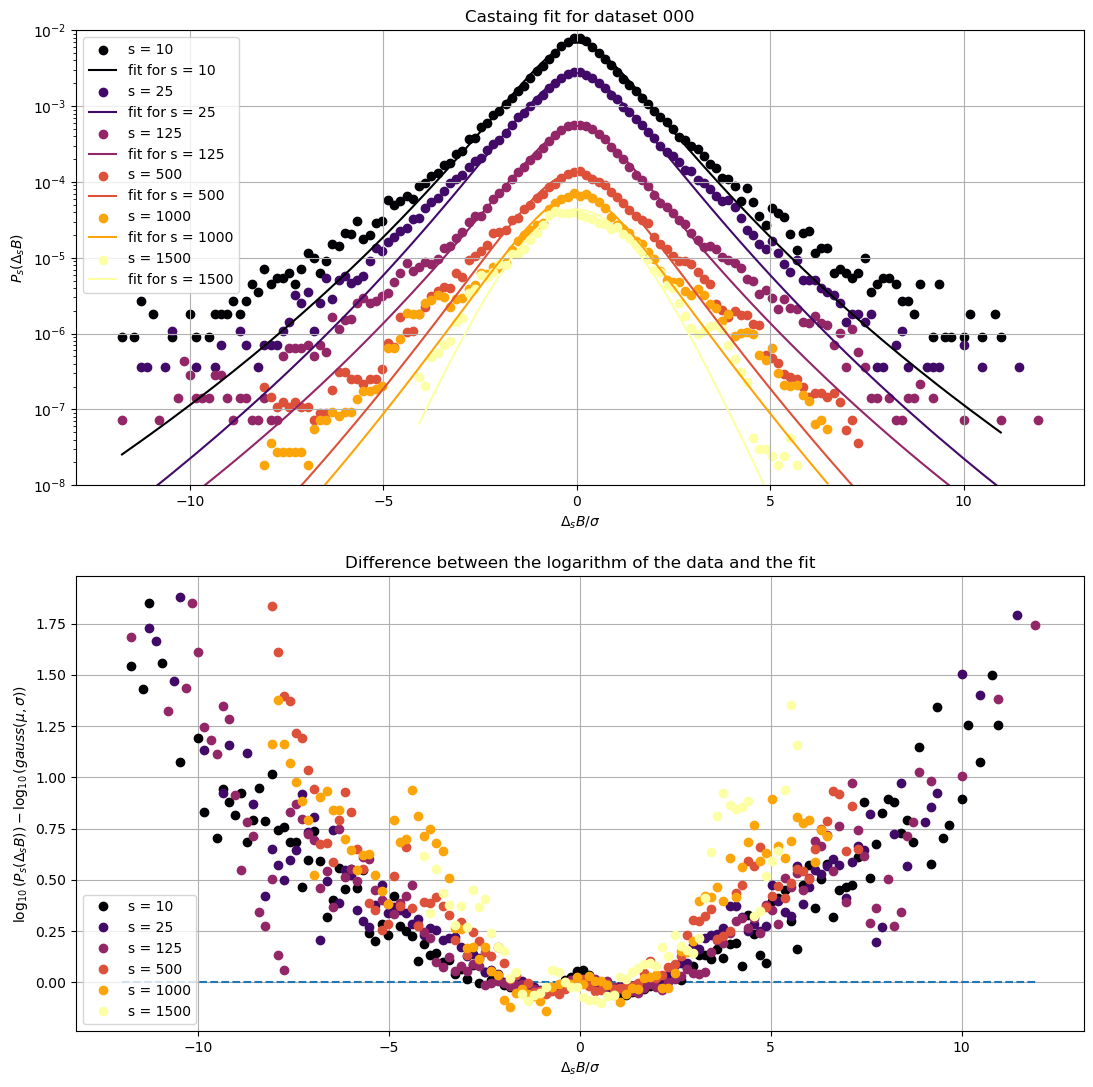

In [ ]:
#lambdas but worse fit

from scipy.integrate import quad_vec
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the colormap for plotting.
colors = plt.cm.inferno(np.linspace(0, 1, len(s_list)))

def Castaing_func(x, lambd):
    def integrand(sigma, x, lambd):
        return 1 / (2 * np.pi * lambd * sigma ** 2) * np.exp(
            - (x ** 2 / sigma ** 2 + np.log(sigma) ** 2 / lambd ** 2) / 2
        )
    # Compute the integral for each x value, starting a bit above zero to avoid singularities.
    results = quad_vec(integrand, 1e-6, np.inf, args=(x, lambd))[0]
    return results

# Vectorize the Castaing function so it works elementwise on arrays.
Castaing = np.vectorize(Castaing_func)

fig, ax = plt.subplots(2, 1, figsize=(13, 13))

ax[0].set_yscale('log')
ax[0].set_ylim(1e-8, 1e-2)
ax[1].hlines(0, -12, 12, linestyles="dashed")
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_title("Castaing fit for dataset 000")
ax[1].set_title("Difference between the logarithm of the data and the fit")
ax[0].set_xlabel(r"$\Delta_s B / \sigma$")
ax[0].set_ylabel(r"$P_s (\Delta_s B)$")
ax[1].set_xlabel(r"$\Delta_s B / \sigma$")
ax[1].set_ylabel(r"$\log_{10}(P_s (\Delta_s B)) - \log_{10}(gauss(\mu, \sigma))$")

df = detr_and_standardize(data, s_list)
for j in range(len(s_list)):
    scale = s_list[j]
    points = df.loc[scale]
    points = points[~np.isnan(points)]

    # Create histogram from the data.
    hist, bins = np.histogram(points, bins=150, range=(-12, 12))
    # Exclude bins with zero counts.
    mask = hist != 0
    centers = (bins[:-1] + bins[1:]) / 2
    centers = centers[mask]
    hist = hist[mask]
    
    # Create a weighting array for the fit.
    # Here, we define a threshold. Bins with |center| > threshold are considered tails.
    threshold = 4.0
    sigma_values = np.ones_like(centers)  # default sigma = 1 for the core
    # For tail bins, assign a smaller sigma (e.g., 0.1) to increase their weight.
    tail_mask = np.abs(centers) > threshold
    sigma_values[tail_mask] = 0.1

    # Fit the log10 of the normalized Castaing function to the log10 of the normalized histogram.
    parameters, cov = curve_fit(
        lambda x, lambd: np.log10(Castaing(x, lambd) / np.trapz(Castaing(x, lambd), x)),
        centers,
        np.log10(hist / np.sum(hist)),
        p0=0.6,
        bounds=[0.1, 1],
        sigma=sigma_values,
        #absolute_sigma=True
    )
    
    print("Fitted lambda for scale", scale, ":", parameters[0])
    
    # Compute the fitted Castaing function and normalize it.
    fit_c = Castaing(centers, parameters[0])
    fit_c = fit_c / (np.sum(fit_c) * scale)
    
    # Prepare normalized histogram for plotting.
    hist_plot = hist / (scale * np.sum(hist))
    ax[0].scatter(centers, hist_plot, color=colors[j], label=f"s = {scale}")
    ax[0].plot(centers, fit_c, color=colors[j], label=f"fit for s = {scale}")
    
    # Compute and plot residuals.
    residuals = np.log10(hist_plot) - np.log10(fit_c)
    ax[1].plot(centers, residuals, 'o', color=colors[j], label=f"s = {scale}")

ax[0].legend()
ax[1].legend()
plt.show()
